In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from tensorflow.keras.applications import EfficientNetB6, ResNet50, VGG16
from tensorflow.keras.utils import plot_model

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*6)])
  except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
    print(e)

In [4]:
base_dir = '../data/telemoji/pre'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(
        rescale=1/255,    
#        rotation_range=40,
#        width_shift_range=0.1,
#        height_shift_range=0.1,
#        zoom_range=0.2,
#        horizontal_flip=True,
#        vertical_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
     rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    color_mode='grayscale',
    target_size=(150,150),
    batch_size=100,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    color_mode='grayscale',
    target_size=(150,150),
    batch_size=100,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    validation_dir,
    color_mode='grayscale',
    target_size=(150,150),
    batch_size=100,
    class_mode='categorical'
)

Found 15986 images belonging to 7 classes.
Found 3992 images belonging to 7 classes.
Found 2074 images belonging to 7 classes.


In [17]:
## 다른 모델 논문 참고 모델
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', 
                 input_shape=(150, 150, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(512, (3, 3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(512, (3, 3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation(tf.nn.leaky_relu))
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(optimizer=RMSprop(learning_rate=1e-4), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 150, 150, 64)      640       
_________________________________________________________________
batch_normalization_30 (Batc (None, 150, 150, 64)      256       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 75, 75, 64)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 75, 75, 128)       73856     
_________________________________________________________________
batch_normalization_31 (Batc (None, 75, 75, 128)       512       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 37, 37, 128)      

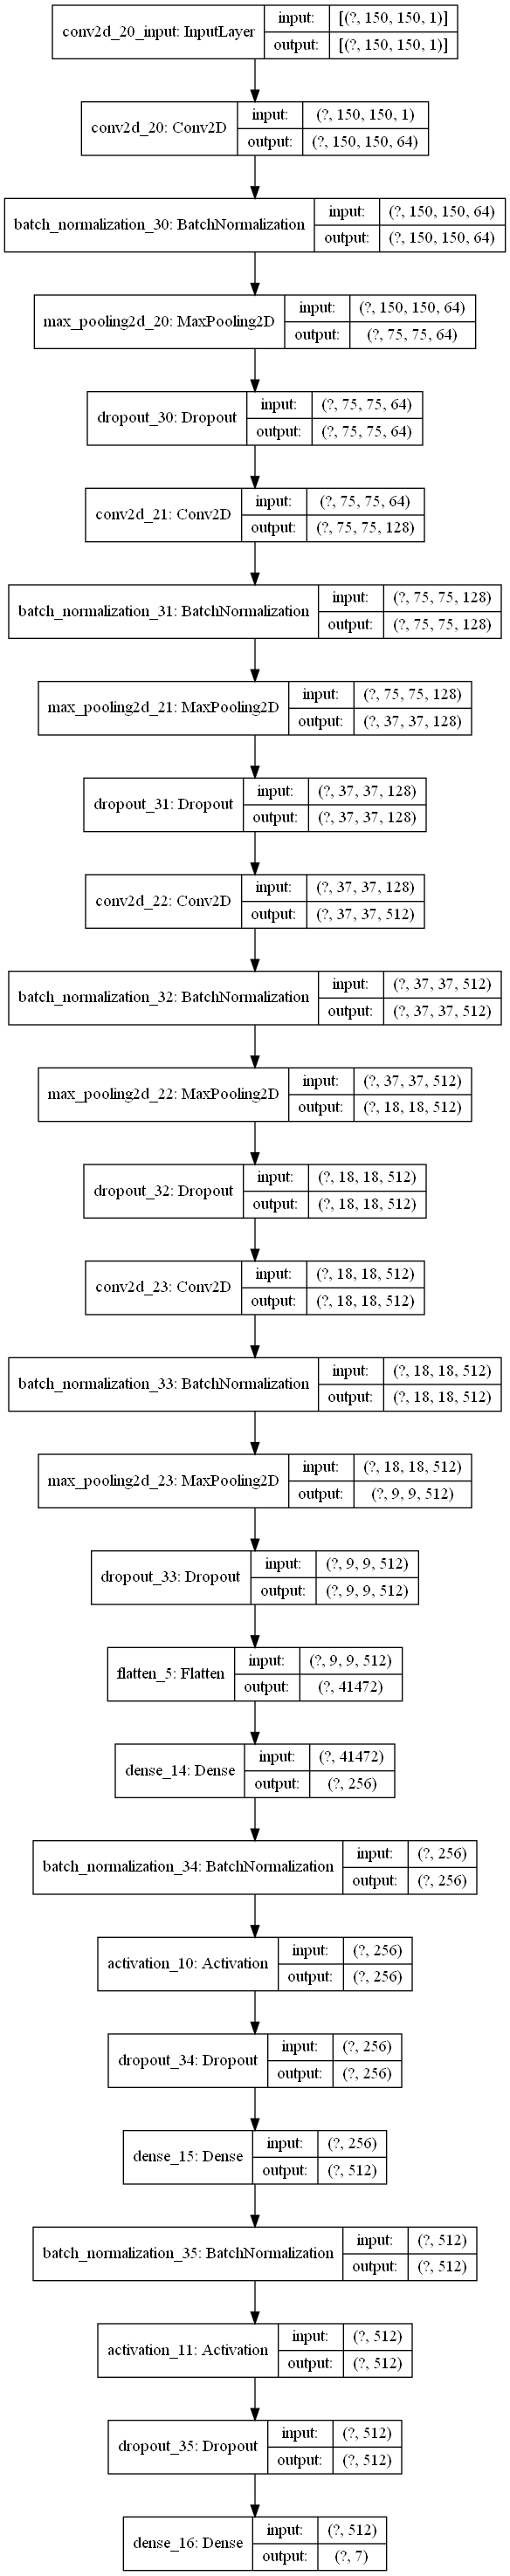

In [23]:
plot_model(model, show_shapes=True, rankdir='TB', dpi=96, 
           to_file='../data/models/논문1_7.png')

In [18]:
history = model.fit(train_generator, steps_per_epoch=159, epochs=30,
                    validation_data=validation_generator, validation_steps=39)

Epoch 1/30
159/159 [==============================] - 55s 344ms/step - loss: 2.1934 - accuracy: 0.2612 - val_loss: 2.0046 - val_accuracy: 0.2851
Epoch 2/30
159/159 [==============================] - 54s 340ms/step - loss: 1.8634 - accuracy: 0.3543 - val_loss: 1.9076 - val_accuracy: 0.2862
Epoch 3/30
159/159 [==============================] - 54s 340ms/step - loss: 1.6962 - accuracy: 0.4061 - val_loss: 1.6410 - val_accuracy: 0.3885
Epoch 4/30
159/159 [==============================] - 54s 338ms/step - loss: 1.5607 - accuracy: 0.4429 - val_loss: 1.6160 - val_accuracy: 0.4126
Epoch 5/30
159/159 [==============================] - 54s 340ms/step - loss: 1.4367 - accuracy: 0.4827 - val_loss: 1.4977 - val_accuracy: 0.4485
Epoch 6/30
159/159 [==============================] - 54s 342ms/step - loss: 1.3266 - accuracy: 0.5190 - val_loss: 1.4965 - val_accuracy: 0.4731
Epoch 7/30
159/159 [==============================] - 54s 340ms/step - loss: 1.2215 - accuracy: 0.5503 - val_loss: 1.4827 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


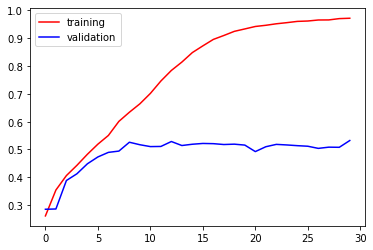

In [21]:
# history 객체 확인
print(history.history.keys())

train_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

train_loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.plot(train_acc, color='r', label='training')
plt.plot(validation_acc, color='b', label='validation')
plt.legend()
plt.savefig('../data/models/논문1_7_acc.jpg')
plt.show()

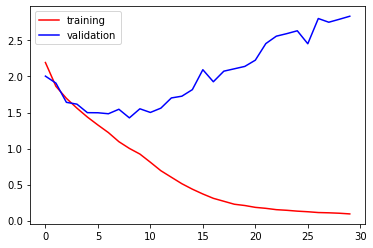

In [22]:
plt.plot(train_loss, color='r', label='training')
plt.plot(validation_loss, color='b', label='validation')
plt.legend()
plt.savefig('../data/models/논문1_7_val.jpg')
plt.show()

In [19]:
result = model.evaluate(test_generator)
print(np.round(result,4))

21/21 [==============================] - 2s 82ms/step - loss: 2.7251 - accuracy: 0.5598
[2.7251 0.5598]


In [20]:
model.save('../data/models/논문1_7.h5')

In [5]:
model = tf.keras.models.load_model('../data/models/논문1_5.h5')
result = model.evaluate(test_generator)
print(result)

21/21 [==============================] - 3s 123ms/step - loss: 1.9409 - accuracy: 0.5574
[1.9409284591674805, 0.5573770403862]
